# Consistent character generation under background maintaining
## Hyperparameters and environment dependencies
The following parameters are consistent with those in `inference.py`, please refer to the detailed instructions in the `README`.

In [ ]:
init_mode = 0
model_path = "/path/to/FLUX.1-dev"
use_interpolate = True
height = 1024
width = 1024
seed = 2025

import copy
import torch
import numpy as np
from PIL import Image

from models.attention_processor_characonsist import (
    reset_attn_processor,
    set_text_len,
)
from models.pipeline_characonsist import CharaConsistPipeline

/home/murray.wang/.conda/envs/easy_ctrl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model initialization functions

In [2]:
def init_model_mode_0():
    pipe = CharaConsistPipeline.from_pretrained(model_path, torch_dtype=torch.bfloat16)
    pipe.to("cuda:0")
    return pipe

def init_model_mode_1():
    pipe = CharaConsistPipeline.from_pretrained(model_path, torch_dtype=torch.bfloat16)
    pipe.enable_model_cpu_offload()
    return pipe

def init_model_mode_2():
    from diffusers import FluxTransformer2DModel
    from transformers import T5EncoderModel
    transformer = FluxTransformer2DModel.from_pretrained(
        model_path, subfolder="transformer", torch_dtype=torch.bfloat16, device_map="balanced")
    text_encoder_2 = T5EncoderModel.from_pretrained(
        model_path, subfolder="text_encoder_2", torch_dtype=torch.bfloat16, device_map="balanced")
    pipe = CharaConsistPipeline.from_pretrained(
        model_path, 
        transformer=transformer,
        text_encoder_2=text_encoder_2,
        torch_dtype=torch.bfloat16, 
        device_map="balanced")
    return pipe

def init_model_mode_3():
    pipe = CharaConsistPipeline.from_pretrained(model_path, torch_dtype=torch.bfloat16)
    pipe.enable_sequential_cpu_offload()
    return pipe


MODEL_INIT_FUNCS = {
    0: init_model_mode_0,
    1: init_model_mode_1,
    2: init_model_mode_2,
    3: init_model_mode_3
}

## Model initialization and processing prompts

Here, we first introduce an example of both foreground and background remaining consistent. Specifically, for a set of image prompts, both the background environment and the foreground character prompts are shared, with only the character action descriptions differing for each image.

During the processing of prompts, we record the length of the background portion and the total length of each prompt, which will further be used to extract the character mask.











In [3]:
def get_text_tokens_length(pipe, p):
    text_mask = pipe.tokenizer_2(
        p,
        padding="max_length",
        max_length=512,
        truncation=True,
        return_length=False,
        return_overflowing_tokens=False,
        return_tensors="pt",
    ).attention_mask
    return text_mask.sum().item() - 1

def modify_prompt_and_get_length(bg, fg, act, pipe):
    bg += " "
    fg += " "
    prompt = bg + fg + act
    return prompt, get_text_tokens_length(pipe, bg), get_text_tokens_length(pipe, prompt)


# An example of generating consistent character within fixed background
bg_prompt = "In a deserted alleyway at night, within a circle of light on the ground,"
fg_prompt = "a stunning female cyber-punk android combatant, white high-tech mechanical body, beautiful face, loose long brown hair,"
act_prompts = [
    "closing eyes, kneeling on both knees, hands resting on the thighs, leaning forward with head lowered, facing the ground, front view",
    "opening eyes, crouching upright, lifting head, looking upward, front view",
    "opening eyes, standing upright with both feet on the ground, staring straight ahead"
]

# Model init
pipe = MODEL_INIT_FUNCS[init_mode]()
reset_attn_processor(pipe, size=(height//16, width//16))

prompts, bg_lens, real_lens = [], [], []
for act_prompt in act_prompts:
    prompt, bg_len, real_len = modify_prompt_and_get_length(copy.deepcopy(bg_prompt), copy.deepcopy(fg_prompt), act_prompt, pipe)
    prompts.append(prompt)
    bg_lens.append(bg_len)
    real_lens.append(real_len)

print("#" * 50)
print(f"all prompts:")
for p in prompts:
    print(p)
print(f"background prompts tokens length: {bg_lens}")
print(f"entire prompts tokens length: {real_lens}")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]


reset attn processor of layer single_transformer_blocks.0.attn.processor
reset attn processor of layer single_transformer_blocks.1.attn.processor
reset attn processor of layer single_transformer_blocks.2.attn.processor
reset attn processor of layer single_transformer_blocks.3.attn.processor
reset attn processor of layer single_transformer_blocks.4.attn.processor
reset attn processor of layer single_transformer_blocks.5.attn.processor
reset attn processor of layer single_transformer_blocks.6.attn.processor
reset attn processor of layer single_transformer_blocks.7.attn.processor
reset attn processor of layer single_transformer_blocks.8.attn.processor
reset attn processor of layer single_transformer_blocks.9.attn.processor
reset attn processor of layer single_transformer_blocks.10.attn.processor
reset attn processor of layer single_transformer_blocks.11.attn.processor
reset attn processor of layer single_transformer_blocks.12.attn.processor
reset attn processor of layer single_transformer

## Identity image generation

Generate the identity image and store necessary intermediate variables in the generation process, e.g., the keys, values and the output tokens of attention layers, so they can be accessed during subsequent frame images generation process and make the frame images consistent with the identity image.

##################################################
Generating ID image ...
38 layers' background and real text length have been reset to 22 and 82.


100%|██████████| 50/50 [01:23<00:00,  1.67s/it]


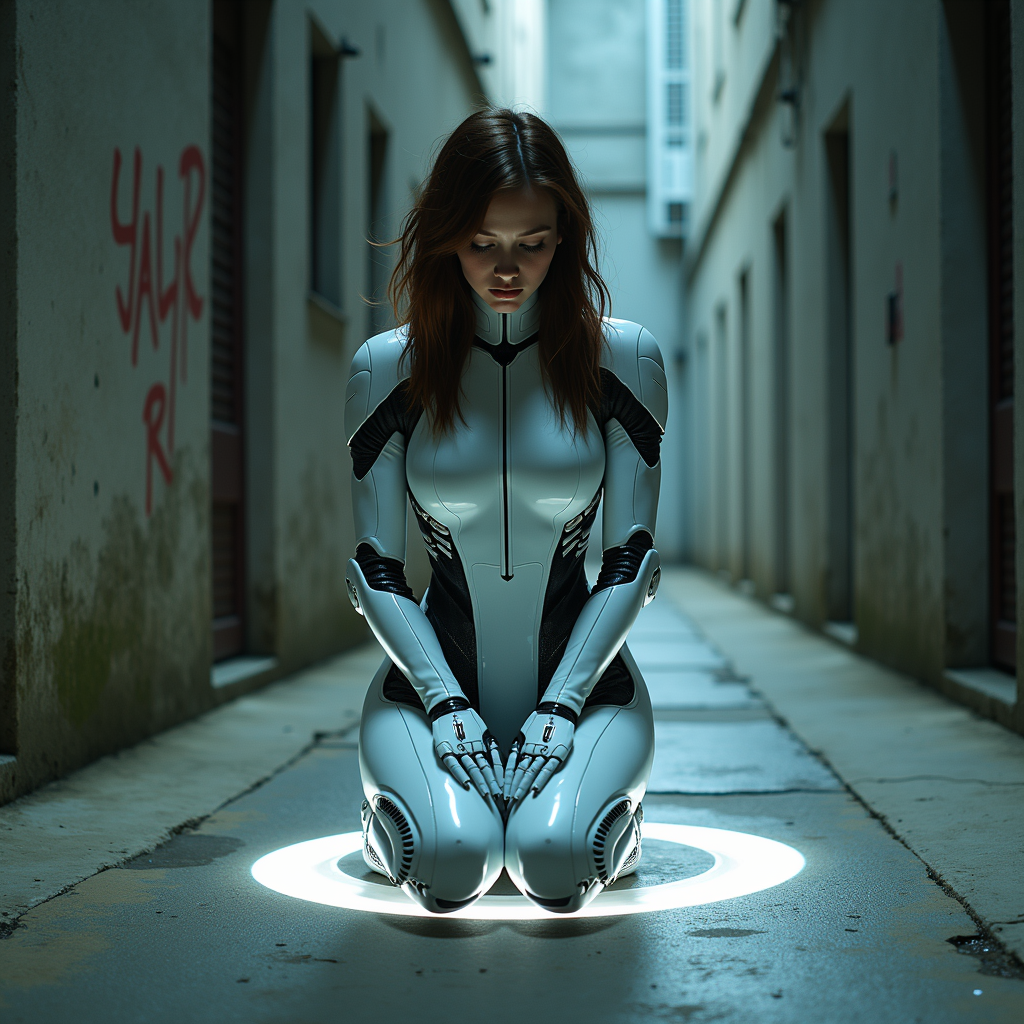

In [4]:
share_bg = True

pipe_kwargs = dict(
    height=height,
    width=width,
    use_interpolate=use_interpolate,
    share_bg=share_bg
)

id_prompt = prompts[0]
frm_prompts = prompts[1:]

print("#" * 50)
print("Generating ID image ...")
set_text_len(pipe, bg_lens[0], real_lens[0])
id_images, id_spatial_kwargs = pipe(
    id_prompt, is_id=True, generator=torch.Generator("cpu").manual_seed(seed), **pipe_kwargs)
id_images[0]

## Mask visualization

Here is an additional visualization that demonstrates the character masks automatically extracted by the model.

We performed additional post-processing after extracting the masks: a 3×3 kernel erosion followed by a 5×5 kernel dilation. The use of a larger dilation kernel helps ensure that the mask captures as much of the foreground content as possible.

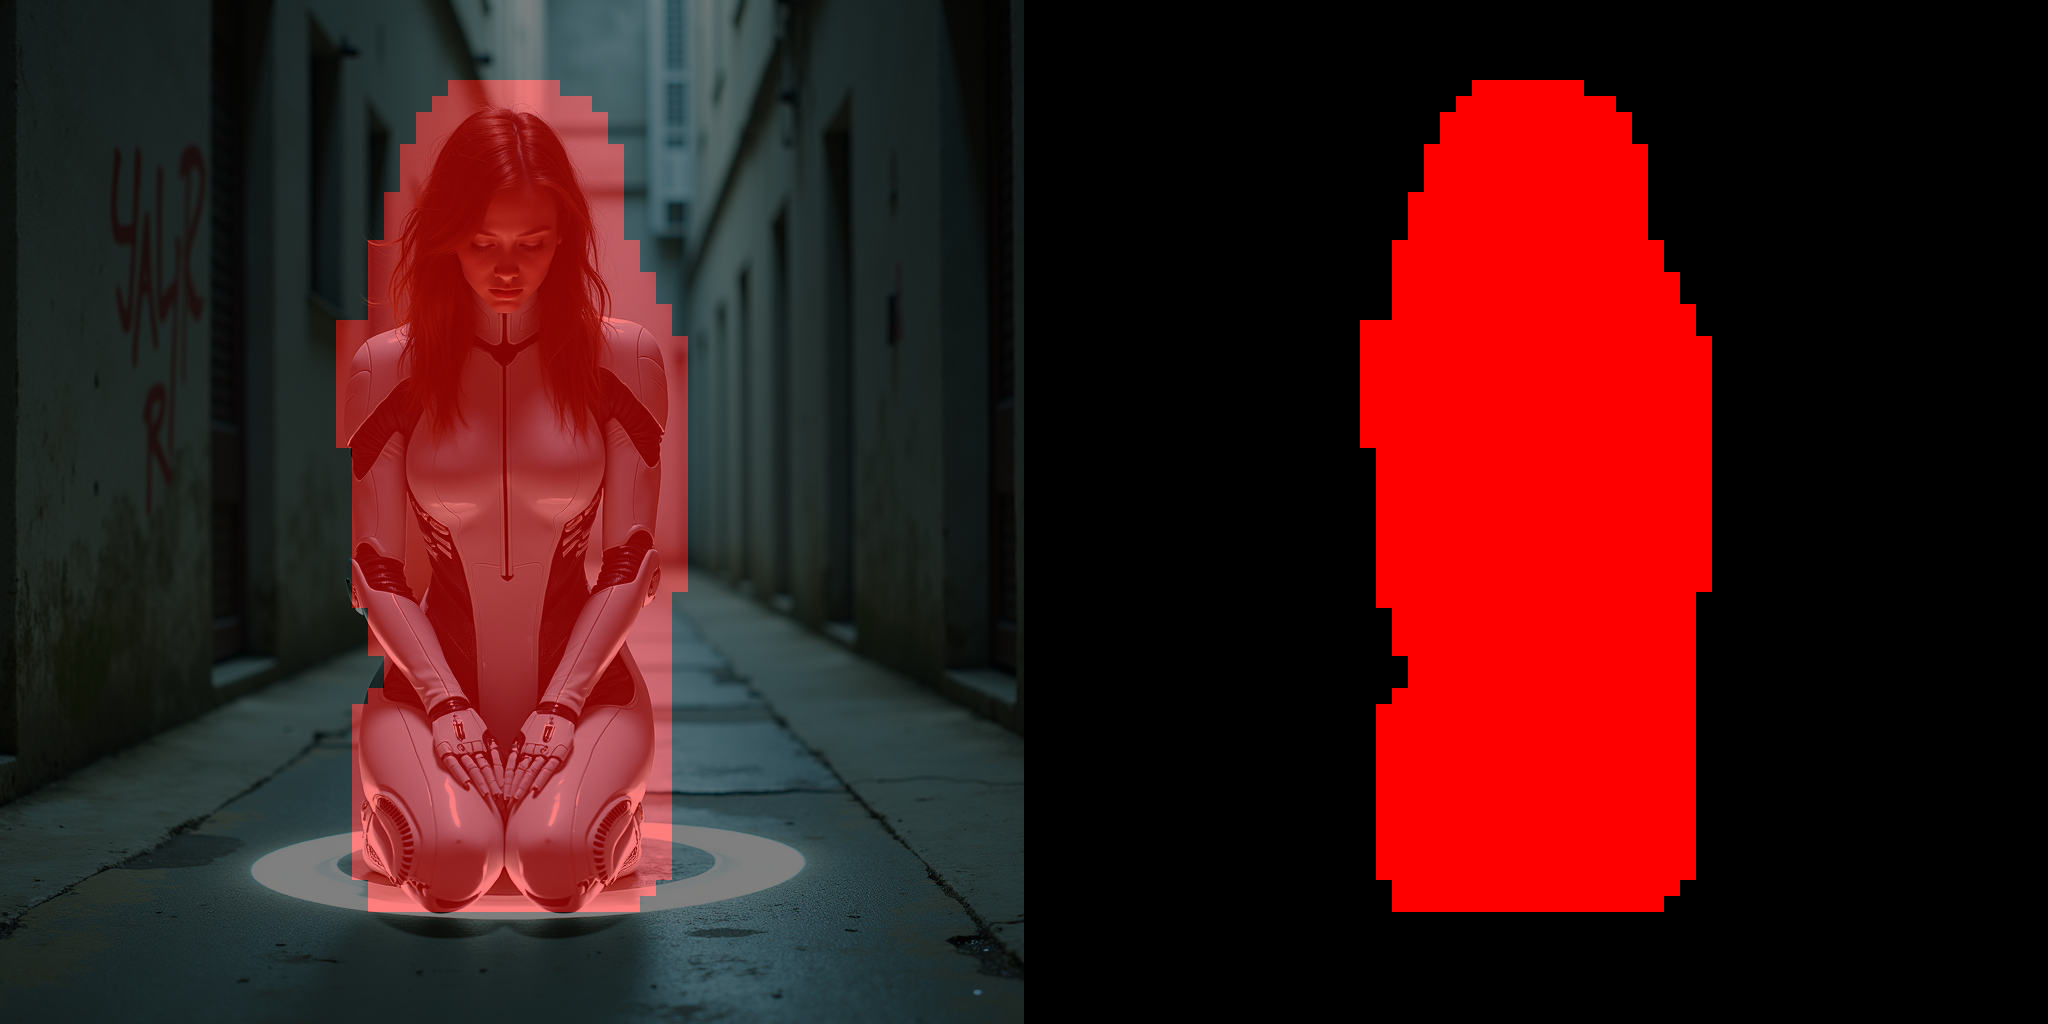

In [5]:
def overlay_mask_on_image(image, mask, color):
    img_array = np.array(image).astype(np.float32) * 0.5
    mask_zero = np.zeros_like(img_array)

    mask_resized = Image.fromarray(mask.astype(np.uint8)).resize(image.size, Image.NEAREST)
    mask_resized = np.array(mask_resized)[:, :, None]
    color = np.array(color, dtype=np.float32).reshape(1, 1, -1)
    mask_resized_color = mask_resized * color
    img_array = img_array + mask_resized_color * 0.5
    mask_zero = mask_zero + mask_resized_color
    out_img = np.concatenate([img_array, mask_zero], axis=1)
    out_img[out_img > 255] = 255
    out_img = out_img.astype(np.uint8)
    return Image.fromarray(out_img)

overlay_mask_on_image(id_images[0], id_spatial_kwargs["curr_fg_mask"][0].cpu().numpy(), (255, 0, 0))

## Frame images generation

The generation process for each frame image consists of two stages: a 10-step "pre-run" followed by the actual generation. The pre-run is used to obtain the mask and point matching results for the current image.

##################################################
Generating frame images ...
38 layers' background and real text length have been reset to 22 and 66.


100%|██████████| 50/50 [01:53<00:00,  2.28s/it]


38 layers' background and real text length have been reset to 22 and 65.


100%|██████████| 50/50 [01:52<00:00,  2.24s/it]


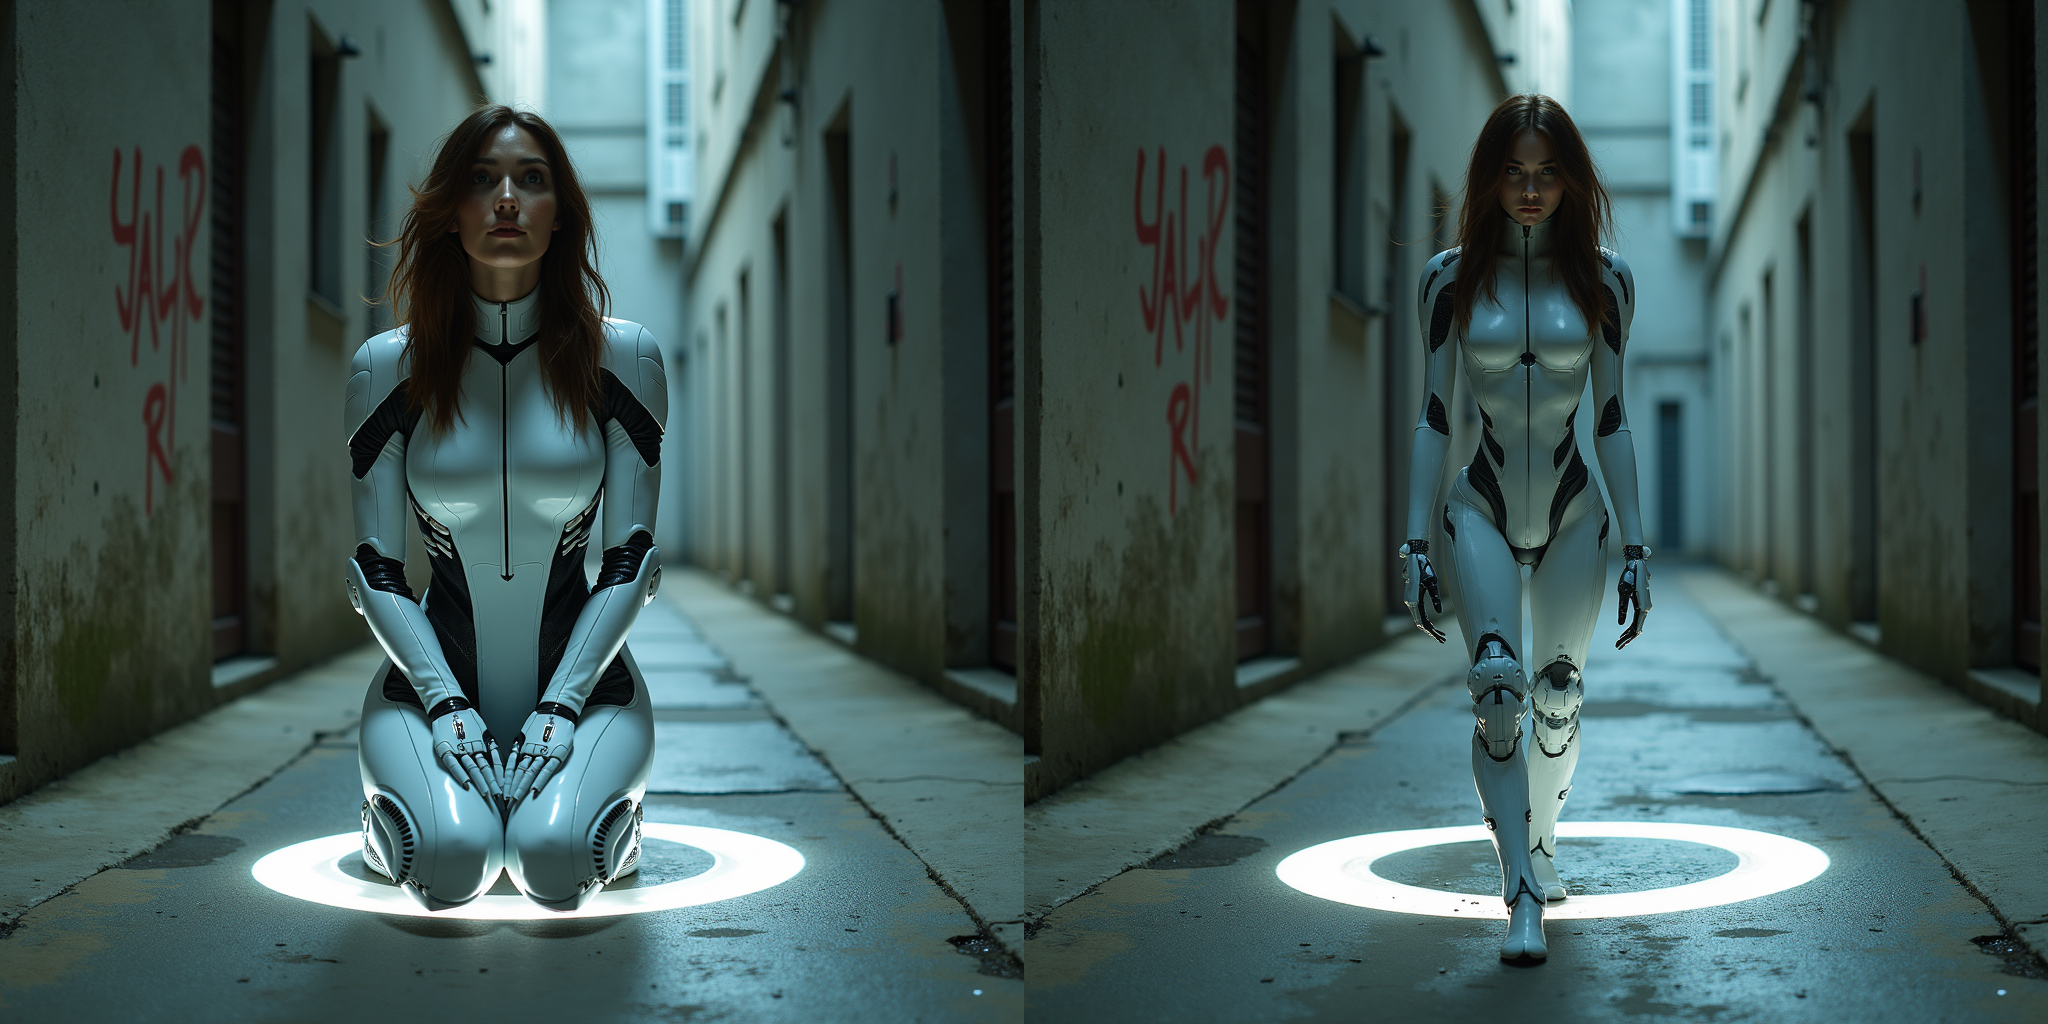

In [8]:
spatial_kwargs = dict(id_fg_mask=id_spatial_kwargs["curr_fg_mask"], id_bg_mask=~id_spatial_kwargs["curr_fg_mask"])

print("#" * 50)
print("Generating frame images ...")
all_images = []
for ind, prompt in enumerate(frm_prompts):
    set_text_len(pipe, bg_lens[1:][ind], real_lens[1:][ind])
    _, spatial_kwargs = pipe(
        prompt, is_pre_run=True, generator=torch.Generator("cpu").manual_seed(seed), spatial_kwargs=spatial_kwargs, **pipe_kwargs)
    images, spatial_kwargs = pipe(
        prompt, generator=torch.Generator("cpu").manual_seed(seed), spatial_kwargs=spatial_kwargs, **pipe_kwargs)
    all_images.append(np.array(images[0]))

import matplotlib.pyplot as plt
all_images = np.hstack(all_images)
Image.fromarray(all_images)